In [2]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook
%pwd

'/mnt/c/Users/mtr22/Code/MRE-PINN/notebooks'

In [3]:
import sys, os, itertools
import numpy as np
import scipy
#import sfepy
import torch
import matplotlib.pyplot as plt

sys.path.append('..')
%aimport mre_pinn

Using backend: pytorch



# Polynomial curve fitting

Define an $n$th order 1-dimensional polynomial as follows:

$$
    p(x) = \sum_{i=0}^{n} c_i x^i
$$

We now define a vector of coefficients $\mathbf{c}$ and a vector of points $\mathbf{x}$:

$$
\begin{align}
    \mathbf{c} &= \left( c_0, c_1, c_2, ..., c_n \right) \\
    \mathbf{x} &= \left( x_1, x_2, ..., x_k \right)
\end{align}
$$

There are $n + 1$ coefficients (one for each power) and $k$ points.

And we define a matrix $\mathbf{A} \in \mathbb{R}^{k \times (n+1)}$ containing powers of $\mathbf{x}$ defined as follows:

$$
    \mathbf{A}_{ij} = x_i^j
$$

We can compute the value of the polynomial at each point like so:

$$
    p(\mathbf{x}) = \mathbf{A} \mathbf{c}
$$

<IPython.core.display.Javascript object>


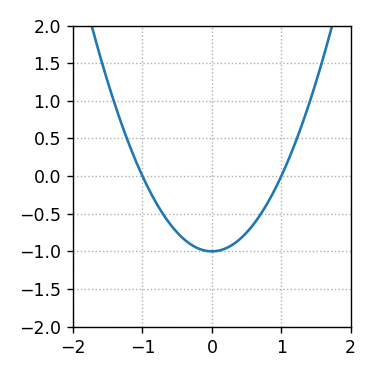

In [6]:
nax = np.newaxis

# define the points
k = 100
x = np.linspace(-2, 2, k)[:,nax]

# define the coefficients
n = 2
c = np.zeros(n + 1)[:,nax]
c[0] = -1
c[1] =  0
c[2] =  1

# create power matrix
powers = np.arange(n + 1)[:,nax]
A = x**powers.T

# compute polynomial
p = A @ c

fig, ax = plt.subplots(figsize=(3,3))
ax.plot(x, p)
ax.set_xlim(x.min(), x.max())
ax.set_ylim(x.min(), x.max())
ax.grid(linestyle=':')
fig.tight_layout()

If we have a dataset of points $(\mathbf{x}_i, \mathbf{y}_i)$, we can fit the polynomial by least squares as follows:

$$
\begin{align}
    \mathbf{A}^\top \mathbf{A} \mathbf{c} &= \mathbf{A}^\top \mathbf{y} \\
    \mathbf{c} &= \left( \mathbf{A}^\top \mathbf{A} \right)^{-1} \mathbf{A}^\top \mathbf{y} \\
    \mathbf{c} &= \mathbf{B} \mathbf{y}
\end{align}
$$

Where the matrix $\mathbf{B}$ is the Moore-Penrose pseudoinverse of $\mathbf{A}$.

[[ 1. -2.  4.]
 [ 1. -1.  1.]
 [ 1.  0.  0.]
 [ 1.  1.  1.]
 [ 1.  2.  4.]]


<IPython.core.display.Javascript object>


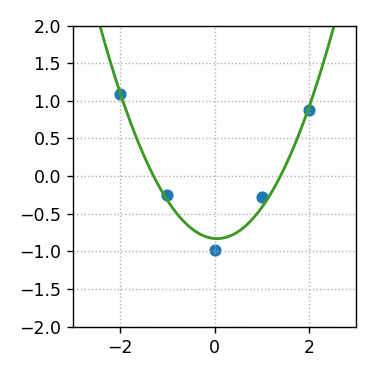

In [7]:
# define the points
k = 5
x = np.linspace(-2, 2, k)[:,nax]

# define the values
y = x**2 / 2 - 1 + 0.2 * np.random.randn(k)[:,nax]

# compute power matrix
n = 2
powers = np.arange(n + 1)[:,nax]
A = x**powers.T
print(A)

# solve for coefficients
c = np.linalg.solve(A.T @ A, A.T @ y)

# also get pseudoinverse of A
B = np.linalg.pinv(A)

fig, ax = plt.subplots(figsize=(3,3))
ax.scatter(x, y)

xx = np.linspace(-3, 3, 100)[:,nax]
AA = xx**powers.T

# plot the solve approach and the pinv approach
ax.plot(xx, AA @ c, color='C1')
ax.plot(xx, AA @ (B @ y), color='C2')

ax.set_xlim(-3, 3)
ax.set_ylim(-2, 2)
ax.grid(linestyle=':')
fig.tight_layout()

## Savitsky-Golay filtering

Now we want to fit a polynomial to local windows of a set of equally-spaced data samples. We should only have to do this once, using the change-of-variables approach where we use the indexes with respect to the center of a convolution kernel. Then we need to use this to get some linear mapping that we can apply to each window of the image and produces the value of the fit polynomial at the center of the window.

[[-2]
 [-1]
 [ 0]
 [ 1]
 [ 2]]
[[0 1 2 3]]
[[ 1. -2.  4. -8.]
 [ 1. -1.  1. -1.]
 [ 1.  0.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 1.  2.  4.  8.]]
[[-8.57142857e-02  3.42857143e-01  4.85714286e-01  3.42857143e-01
  -8.57142857e-02]
 [ 8.33333333e-02 -6.66666667e-01  6.17335241e-17  6.66666667e-01
  -8.33333333e-02]
 [ 2.85714286e-01 -1.42857143e-01 -2.85714286e-01 -1.42857143e-01
   2.85714286e-01]
 [-5.00000000e-01  1.00000000e+00 -4.87374346e-17 -1.00000000e+00
   5.00000000e-01]]


<IPython.core.display.Javascript object>


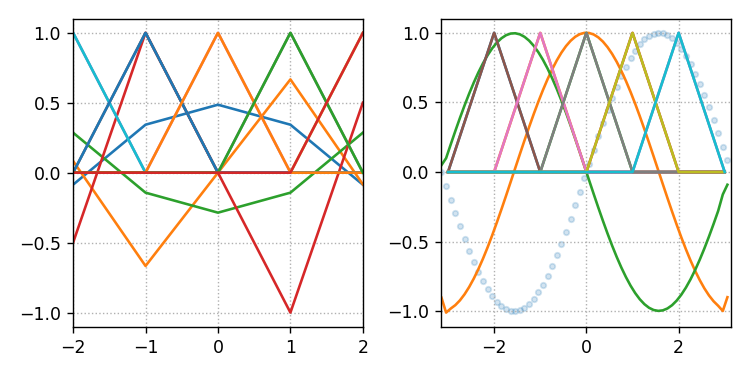

In [8]:
def sg_filter_nd(n, order=2, kernel_size=3, deriv=None):
    assert kernel_size % 2 == 1, 'kernel_size must be odd'
    
    # coordinates of kernel values
    half_size = kernel_size // 2
    coords = np.arange(-half_size, half_size + 1)
    coords = np.stack(np.meshgrid([coords] * n)).reshape(-1, n)
    n_values = len(coords)
    
    print(coords)
    
    # powers of polynomial terms
    powers = np.arange(order + 1)
    powers = np.stack(np.meshgrid([powers] * n)).reshape(-1, n)
    powers = powers[powers.sum(axis=1) <= order]
    n_terms = len(powers)
    
    print(powers.T)
    
    assert n_values >= n_terms, 'order is too high for kernel_size'
    
    # set up linear system of equations
    A = np.zeros((n_values, n_terms))
    for i in range(n_values):
        for j in range(n_terms):
            A[i,j] = np.power(coords[i], powers[j]).prod()
    print(A)
            
    B = np.linalg.pinv(A)
    
    # this factor is needed for derivatives
    B *= scipy.special.factorial(powers)
    
    print(B)

    return coords[:,0], B

coords, B = sg_filter_nd(n=1, order=3, kernel_size=5)

fig, axes = plt.subplots(1, 2, figsize=(6,3))

axes[0].plot(coords, B.T)
axes[0].set_xlim(-2, 2)
axes[0].grid(linestyle=':')

h = 0.1
x = np.arange(-np.pi, np.pi, h)
y = np.sin(x) # + np.random.randn(n) * 0.01
h = x[1] - x[0]

Y = scipy.ndimage.convolve(y, -B[1], mode='wrap') / h
YY = np.gradient(np.gradient(y, h), h)

axes[1].scatter(x, y, s=10, alpha=0.2)
axes[1].plot(x, Y, color='C1')
axes[1].plot(x, YY, color='C2')
axes[1].set_xlim(-np.pi, np.pi)
axes[1].grid(linestyle=':')

fig.tight_layout()

# 1D Poisson forward FEM

Following FEM wikipedia page we have for $u: [-1, 1] \to \mathbb{R}$ and $f: [-1, 1] \to \mathbb{R}$:

$$
\begin{align}
    u''(x) &= f(x) \\
    u(-1) &= 0 \\
    u(1) &= 0
\end{align}
$$

We are given $f$ and the above PDE and boundary conditions, and we would like to solve for $u$.

Variational form:

$$
\begin{align}
    \int_{-1}^1 u''(x)v(x) dx &= \int_{-1}^1 f(x)v(x) dx \quad \forall v
\end{align}
$$

Integration by parts:

$$
\begin{align}
    \int_{-1}^1 u''(x)v(x) dx &= u'(x)v(x) \vert_{-1}^1 - \int_{-1}^1 u'(x)v'(x) dx \\
    \int_{-1}^1 u''(x)v(x) dx &= - \int_{-1}^1 u'(x)v'(x) dx \\
    - \int_{-1}^1 u'(x)v'(x) dx &= \int_{-1}^1 f(x)v(x) dx \\
    \int_{-1}^1 u'(x)v'(x) dx &= -\int_{-1}^1 f(x)v(x) dx
\end{align}
$$

Domain discretization by 1D uniform mesh with $n$ nodes, for $i = [0, 1, ..., n - 1]$:

$$
    x_i = \frac{i}{n - 1}
$$

Basis functions:

$$
\begin{align}
    u(x) = \sum_{i=0}^{n - 1} u_i \phi_i(x) \\
    f(x) = \sum_{i=0}^{n - 1} f_i \phi_i(x) \\
    v(x) = \sum_{i=0}^{n - 1} v_i \phi_i(x)
\end{align}
$$

Substitute and derive:

$$
\begin{align}
    \int_{-1}^1 \left( \sum_{i=0}^{n - 1} u_i \phi_i(x) \right)' \phi_j'(x) dx &= -\int_{-1}^1 \left( \sum_{i=0}^{n - 1} f_i \phi_i(x) \right) \phi_j(x) dx \\
    \int_{-1}^1 \left( \sum_{i=0}^{n - 1} u_i \phi'_i(x) \right) \phi_j'(x) dx &= -\int_{-1}^1 \left( \sum_{i=0}^{n - 1} f_i \phi_i(x) \right) \phi_j(x) dx \\
    \int_{-1}^1 \sum_{i=0}^{n - 1} u_i \phi'_i(x) \phi_j'(x) dx &= -\int_0^1 \sum_{i=0}^{n - 1} f_i \phi_i(x) \phi_j(x) dx \\
    \sum_{i=0}^{n - 1} u_i \left(\int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \right) &= -\sum_{i=0}^{n - 1} f_i \left( \int_{-1}^1 \phi_i(x) \phi_j(x) dx \right)
\end{align}
$$

Assemble FEM matrices:

$$
\begin{align}
    \mathbf{K}_{ij} &= \int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \\
    \mathbf{M}_{ij} &= \int_{-1}^1 \phi_i(x) \phi_j(x) dx
\end{align}
$$

Linear system:

$$
    \mathbf{K} \mathbf{u} = -\mathbf{M} \mathbf{f}
$$

<IPython.core.display.Javascript object>


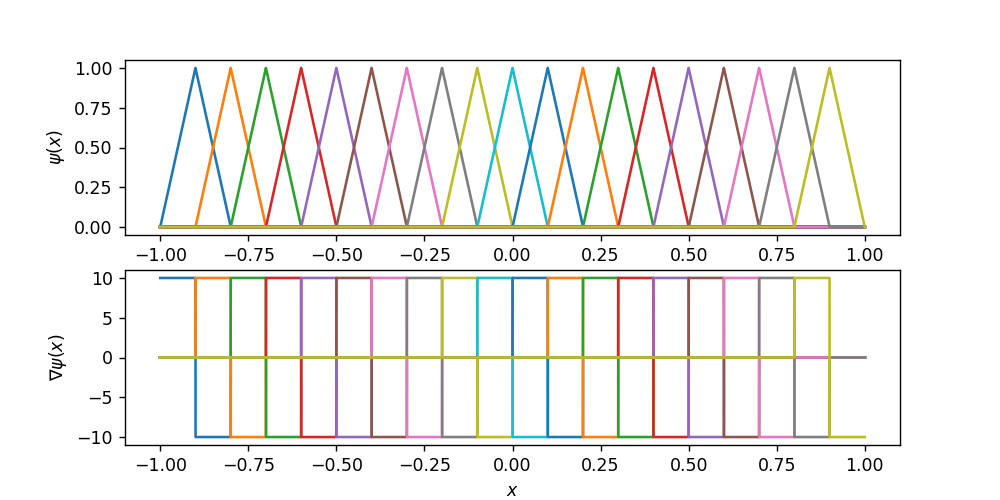

Text(0.5, 0, '$x$')

In [180]:
# define a piecewise linear basis function

def psi(x, nodes, radius=1):
    '''
    Evaluate piecewise linear basis functions.
    
    Args:
        x: (N, D) array of positions to evaluate.
        nodes: (M, D) array of node locations.
        radius: Scalar radius of basis functions.
    Returns:
        (M, N) array of basis function values.
    '''
    nax = np.newaxis
    diff = (nodes[:,nax] - x[nax,:]) / radius
    dist = torch.norm(diff, np.inf, dim=2)
    return torch.clamp(1 - dist, min=0)

# define the mesh (number of basis functions)
ndim = 1
n_nodes = 21
nax = np.newaxis
nodes = torch.linspace(-1, 1, n_nodes)[:,nax]

# mesh resolution
d_node = nodes[1] - nodes[0]

# remove boundary nodes
nodes = nodes[1:-1]
n_nodes = len(nodes)

# domain samples (integral resolution)
n_samples = 50001
x = torch.linspace(-1, 1, n_samples)[:,nax]
x.requires_grad = True

# sample resolution
dx = x[1] - x[0]

psi_x = psi(x, nodes, d_node)

# evaluate gradient of each basis function
grad_psi_x = torch.zeros((n_nodes**ndim, n_samples**ndim, ndim))
for i in range(n_nodes**ndim):
    grad_psi_x[i] = torch.autograd.grad(psi_x[i], x, torch.ones_like(psi_x[i]), retain_graph=True)[0]
    
fig, axes = plt.subplots(2, 1, figsize=(8,4))
axes[0].plot(x.detach().cpu().numpy(), psi_x.detach().cpu().numpy().T, label=range(n_nodes))
axes[1].plot(x.detach().cpu().numpy(), grad_psi_x.detach().cpu().numpy()[...,0].T, label=range(n_nodes))
axes[0].set_ylabel(r'$\psi(x)$')
axes[1].set_ylabel(r'$\nabla\psi(x)$')
axes[1].set_xlabel(r'$x$')

In [181]:
# assemble FEM matrices

# compute basis function products needed for variational form of PDE
M_products = (psi_x[:,nax,:] * psi_x[nax,:,:])
K_products = (grad_psi_x[:,nax,...] * grad_psi_x[nax,:,...]).sum(dim=-1)

# Riemann integrals of basis function products
M = (M_products * dx).sum(dim=-1)
K = (K_products * dx).sum(dim=-1)

print(M.shape, K.shape)

torch.Size([19, 19]) torch.Size([19, 19])


<IPython.core.display.Javascript object>


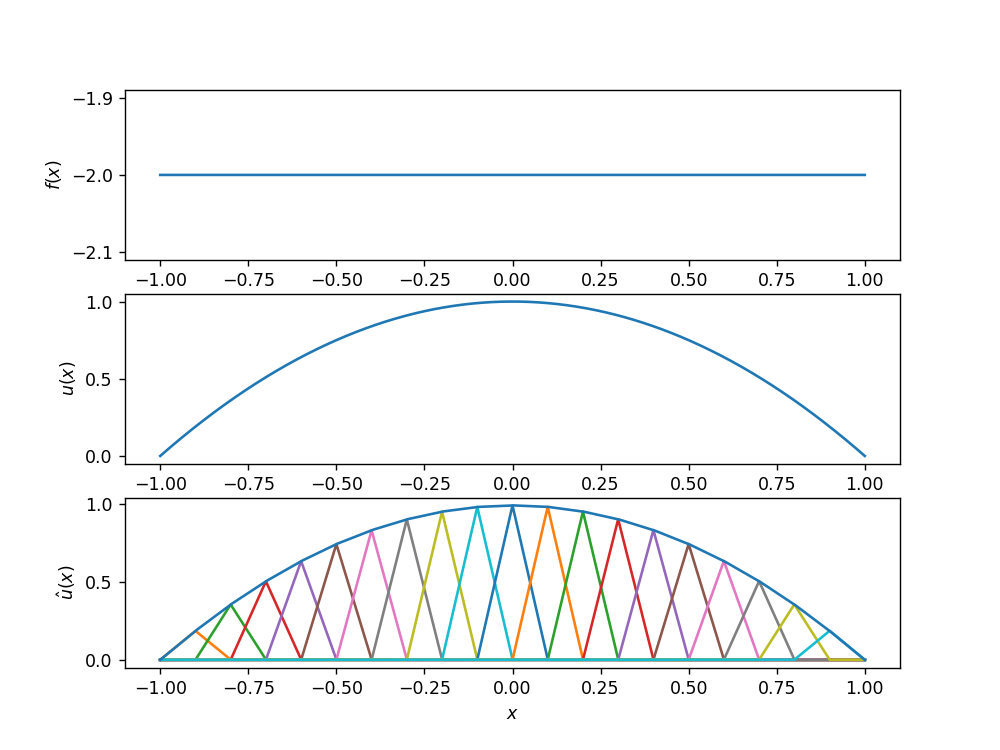

Text(0.5, 0, '$x$')

In [182]:
def f(x):
    '''True forcing function.'''
    return -2 * torch.ones_like(x)

def u(x):
    '''True displacement function.'''
    return 1 - x**2

# sample forcing function on mesh and over full domain
f_h = f(nodes)
f_x = f(x)

# sample true displacement function on mesh and over full domain
u_h = u(nodes)
u_x = u(x)

# solve linear system of equations
uhat_h = torch.linalg.solve(K, -M @ f_h)

# linear combination of basis functions
uhat_psi_x = (uhat_h * psi_x)
uhat_x = uhat_psi_x.sum(dim=0, keepdim=True).T

fig, axes = plt.subplots(3, 1, figsize=(8,6))
axes[0].plot(x.detach().cpu().numpy(), f_x.detach().cpu().numpy(), label=range(n_nodes))
axes[1].plot(x.detach().cpu().numpy(), u_x.detach().cpu().numpy(), label=range(n_nodes))
axes[2].plot(x.detach().cpu().numpy(), uhat_x.detach().cpu().numpy(), label=range(n_nodes))
axes[2].plot(x.detach().cpu().numpy(), uhat_psi_x.detach().cpu().numpy().T, label=range(n_nodes), zorder=0)
axes[0].set_ylabel(r'$f(x)$')
axes[1].set_ylabel(r'$u(x)$')
axes[2].set_ylabel(r'$\hat{u}(x)$')
axes[-1].set_xlabel(r'$x$')

# 1D Poisson inverse FEM

Similar problem setup as before:

$$
\begin{align}
    u''(x) &= f(x) \\
    u(-1) &= 0 \\
    u(1) &= 0
\end{align}
$$

But now we are given $u$ and we want to infer the forcing function $f$.

Variational form is the same:

$$
\begin{align}
    \int_{-1}^1 u''(x)v(x) dx &= \int_{-1}^1 f(x)v(x) dx \quad \forall v
\end{align}
$$

Integration by parts (note we cannot drop the boundary integral now, since $v$ is in the same space as $f$, which may not be zero on the boundary):

$$
\begin{align}
    \int_{-1}^1 u''(x)v(x) dx &= u'(x)v(x) \vert_{-1}^1 - \int_{-1}^1 u'(x)v'(x) dx \\
    u'(x)v(x) \vert_{-1}^1 - \int_{-1}^1 u'(x)v'(x) dx &= \int_{-1}^1 f(x)v(x) dx \\
    \int_{-1}^1 u'(x)v'(x) dx - u'(x)v(x) \vert_{-1}^1 &= -\int_{-1}^1 f(x)v(x) dx
\end{align}
$$

Domain discretization by 1D uniform mesh with $n$ nodes, for $i = [0, 1, ..., n - 1]$:

$$
    x_i = \frac{i}{n - 1}
$$

Basis functions:

$$
\begin{align}
    u(x) = \sum_{i=0}^{n - 1} u_i \phi_i(x) \\
    f(x) = \sum_{i=0}^{n - 1} f_i \phi_i(x) \\
    v(x) = \sum_{i=0}^{n - 1} v_i \phi_i(x)
\end{align}
$$

Substitute and derive:

$$
\begin{align}
    \int_{-1}^1 \left( \sum_{i=0}^{n - 1} u_i \phi_i(x) \right)' \phi_j'(x) dx - {\left( \sum_{i=0}^{n - 1} u_i \phi_i(x) \right)' \phi_j(x)} \vert_{-1}^1 &= -\int_{-1}^1 \left( \sum_{i=0}^{n - 1} f_i \phi_i(x) \right) \phi_j(x) dx \\
    \int_{-1}^1 \left( \sum_{i=0}^{n - 1} u_i \phi'_i(x) \right) \phi_j'(x) dx - \left( \sum_{i=0}^{n - 1} u_i \phi_i'(x) \right) \phi_j(x) \vert_{-1}^1 &= -\int_{-1}^1 \left( \sum_{i=0}^{n - 1} f_i \phi_i(x) \right) \phi_j(x) dx \\
    \int_{-1}^1 \sum_{i=0}^{n - 1} u_i \phi'_i(x) \phi_j'(x) dx - \sum_{i=0}^{n - 1} u_i \phi_i'(x) \phi_j(x) \vert_{-1}^1 &= -\int_{-1}^1 \sum_{i=0}^{n - 1} f_i \phi_i(x) \phi_j(x) dx \\
    \sum_{i=0}^{n - 1} u_i \left[ \left( \int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \right) - \phi_i'(x) \phi_j(x) \vert_{-1}^1 \right] &= -\sum_{i=0}^{n - 1} f_i \left( \int_{-1}^1  \phi_i(x) \phi_j(x) dx \right) \\
    \sum_{i=0}^{n - 1} f_i \left( \int_{-1}^1  \phi_i(x) \phi_j(x) dx \right) &= \sum_{i=0}^{n - 1} u_i \left[ \phi_i'(x) \phi_j(x) \vert_{-1}^1 - \left( \int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \right) \right]
\end{align}
$$

Assemble FEM matrices:

$$
\begin{align}
    \mathbf{M}_{ij} &= \int_{-1}^1 \phi_i(x) \phi_j(x) dx \\
    \mathbf{K}_{ij} &= \int_{-1}^1 \phi'_i(x) \phi_j'(x) dx \\
    \mathbf{T}_{ij} &= \phi_i'(x) \phi_j(x) \vert_{-1}^1
\end{align}
$$

Linear system:

$$
    \mathbf{M} \mathbf{f} = \left( \mathbf{T} - \mathbf{K} \right) \mathbf{u}
$$

<IPython.core.display.Javascript object>


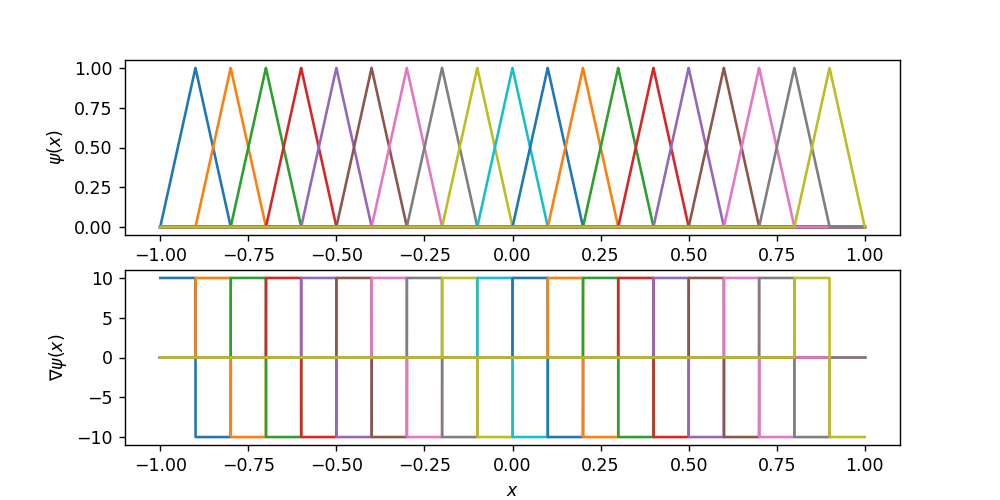

Text(0.5, 0, '$x$')

In [183]:
# define the mesh
ndim = 1
n_nodes = 21
nax = np.newaxis
nodes = torch.linspace(-1, 1, n_nodes)[:,nax]

# mesh resolution
d_node = nodes[1] - nodes[0]

# remove boundary nodes
nodes = nodes[1:-1]
n_nodes -= 2

# domain samples
n_samples = 40001
x = torch.linspace(-1, 1, n_samples)[:,nax]
x.requires_grad = True

# sample resolution
dx = x[1] - x[0]

psi_x = psi(x, nodes, d_node)

# evaluate gradient of each basis function
grad_psi_x = torch.zeros((n_nodes**ndim, n_samples**ndim, ndim))
for i in range(n_nodes**ndim):
    grad_psi_x[i] = torch.autograd.grad(psi_x[i], x, torch.ones_like(psi_x[i]), retain_graph=True)[0]
    
fig, axes = plt.subplots(2, 1, figsize=(8,4))
axes[0].plot(x.detach().cpu().numpy(), psi_x.detach().cpu().numpy().T, label=range(n_nodes))
axes[1].plot(x.detach().cpu().numpy(), grad_psi_x.detach().cpu().numpy()[...,0].T, label=range(n_nodes))
axes[0].set_ylabel(r'$\psi(x)$')
axes[1].set_ylabel(r'$\nabla\psi(x)$')
axes[1].set_xlabel(r'$x$')

We will now assemble the FEM matrices, but we need to include a traction matrix:
    
$$
\begin{align}
    \mathbf{T}_{ij} &= \phi_i'(x) \phi_j(x) \vert_{-1}^1 \\
    \mathbf{T}_{ij} &= \phi_i'(1) \phi_j(1) - \phi_i'(-1) \phi_j(-1) \\
    \mathbf{T}_{ij} &= \int_\Gamma n\phi_i'(x) \phi_j(x) dx \\
\end{align}
$$

Where $n$ is the boundary normal, i.e. $n = 1$ for the right boundary and $n = -1$ for the left boundary.

In [184]:
# get the boundary normals
normal = torch.zeros(n_samples, ndim)
left_boundary = (x[:,0] == -1)
right_boundary = (x[:,0] == 1)
normal[left_boundary,0] = -1
normal[right_boundary,0] = 1
normal.shape

torch.Size([40001, 1])

In [185]:
# compute basis function products and integrals

M_products = (psi_x[:,nax,:] * psi_x[nax,:,:])
T_products = (psi_x[:,nax,:,nax] * grad_psi_x[nax,:] * normal[nax,nax]).sum(dim=-1) # dot product
K_products = (grad_psi_x[:,nax,...] * grad_psi_x[nax,:,...]).sum(dim=-1) # dot product

# simple Riemannian integration
M = (M_products * dx).sum(dim=-1)
T = (T_products).sum(dim=-1)
K = (K_products * dx).sum(dim=-1)

print(M.shape, T.shape, K.shape)

torch.Size([19, 19]) torch.Size([19, 19]) torch.Size([19, 19])


<IPython.core.display.Javascript object>


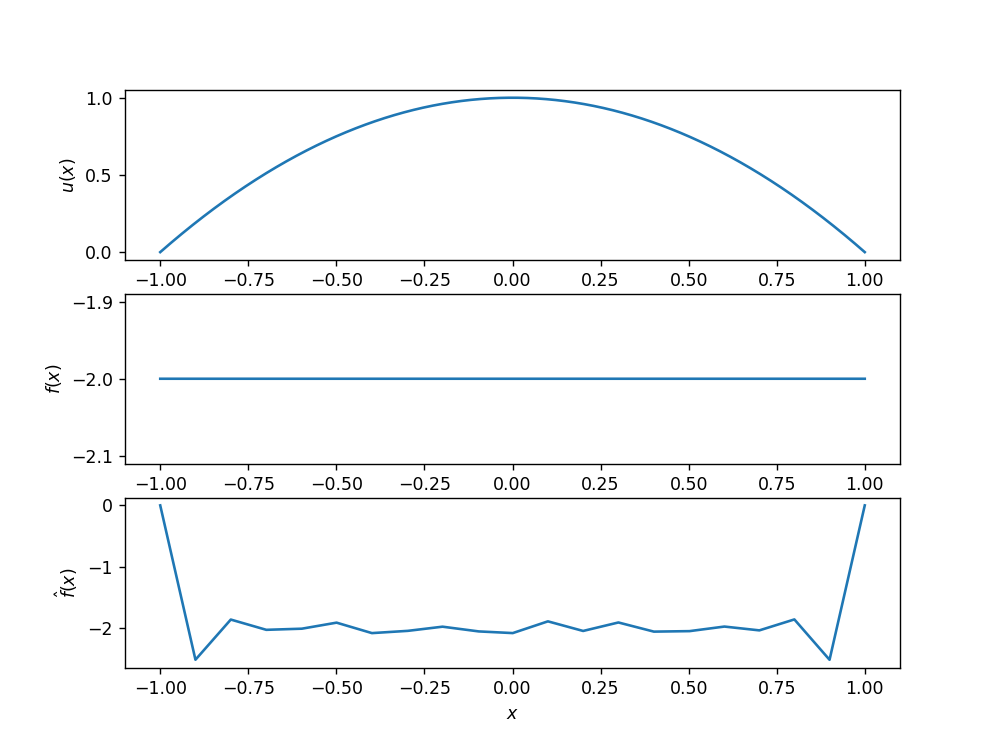

Text(0.5, 0, '$x$')

In [186]:
def f(x):
    '''True forcing function.'''
    return -2 * torch.ones_like(x)

def u(x):
    '''True displacement function.'''
    return 1 - x**2

# sample forcing function on mesh and over full domain
f_h = f(nodes)
f_x = f(x)

# sample true displacement function on mesh and over full domain
u_h = u(nodes)
u_x = u(x)

# solve linear system of equations
fhat_h = torch.linalg.solve(M, -K @ u_h)

# linear combination of basis functions
fhat_psi_x = (fhat_h * psi_x)
fhat_x = fhat_psi_x.sum(dim=0, keepdim=True).T

fig, axes = plt.subplots(3, 1, figsize=(8,6))
axes[0].plot(x.detach().cpu().numpy(), u_x.detach().cpu().numpy(), label=range(n_nodes))
axes[1].plot(x.detach().cpu().numpy(), f_x.detach().cpu().numpy(), label=range(n_nodes))
axes[2].plot(x.detach().cpu().numpy(), fhat_x.detach().cpu().numpy(), label=range(n_nodes))
#axes[2].plot(x.detach().cpu().numpy(), fhat_psi_x.detach().cpu().numpy().T, label=range(n_nodes), zorder=0)
axes[0].set_ylabel(r'$u(x)$')
axes[1].set_ylabel(r'$f(x)$')
axes[2].set_ylabel(r'$\hat{f}(x)$')
axes[-1].set_xlabel(r'$x$')

## Helmholtz equation inverse problem

Strong form:

$$
\begin{align}
    \mu \nabla^2 \mathbf{u} + \rho \omega^2 \mathbf{u} &= 0 \\
    \mu \nabla^2 \mathbf{u}_k + \rho \omega^2 \mathbf{u}_k &= 0 \\
    \mu \left( \sum_i \frac{\partial^2 \mathbf{u}_k}{\partial \mathbf{x}_i^2} \right) + \rho \omega^2 \mathbf{u}_k &= 0
\end{align}
$$

Variational form:

$$
\begin{align}
    \int_\Omega \mu \nabla \mathbf{u} \cdot \nabla \mathbf{w} d\Omega &= \rho \omega^2 \int_\Omega \mathbf{u} \mathbf{w} d\Omega \\
    \int_\Omega \mu \left( \frac{\partial \mathbf{u}_k}{\partial \mathbf{x}_i} \right) \cdot \left( \frac{\partial \mathbf{w}_k}{\partial \mathbf{x}_i} \right) d\Omega &= \rho \omega^2 \int_\Omega \left( \mathbf{u}_i \right) \cdot \left( \mathbf{w}_i \right) d\Omega
\end{align}
$$

Basis functions:

$$
\begin{align}
    w_k^h &= \sum_i^N \psi_i \\
    u_k^h &= \sum_j^N u_{kj} \psi_j \\
    \mu^h &= \sum_j^N \mu_j \psi_j
\end{align}
$$

In [5]:
# load the data set

data, test_data = mre_pinn.data.load_bioqic_dataset(
    data_root='../data/BIOQIC',
    data_name='fem_box',
    frequency=80,
    xyz_slice='1D',
    downsample=2
)
ndim = 1

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128
Loading ../data/BIOQIC/fem_box_elastogram.npy
     <class 'numpy.ndarray'> (6, 10, 80, 100) complex128
Loading ../data/BIOQIC/fem_box_regions.npy
     <class 'numpy.ndarray'> (10, 80, 100) int64
Single frequency 1D
<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, component: 1)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
    y               float64 0.075
    z               float64 0.0
  * component       (component) <U1 'z'
Data variables:
    u               (frequency, x, component) complex128 (-2.0610768547282833...
    mu              (frequency, x) complex128 (3000+502.6548245743669j) ... (...
    spatial_region  (x) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0


<IPython.core.display.Javascript object>


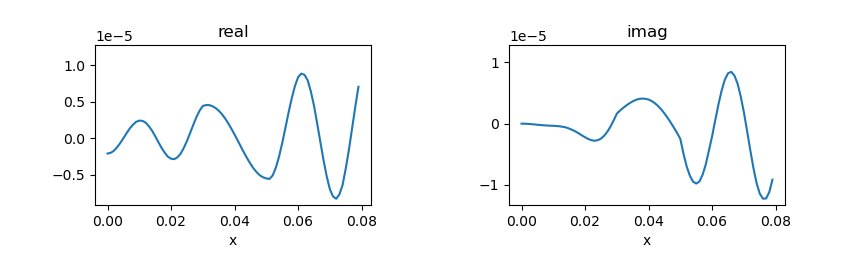

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [6]:
wave_kws = mre_pinn.visual.get_color_kws(data.u)

mre_pinn.visual.XArrayViewer(data.u, y=None, col='part', dpi=25, **wave_kws)

Creating nodes and domain samples
torch.Size([5, 1]) torch.Size([1400, 1])
Evaluating basis functions and gradients
torch.Size([5, 1400]) torch.Size([5, 1400, 1])


<IPython.core.display.Javascript object>


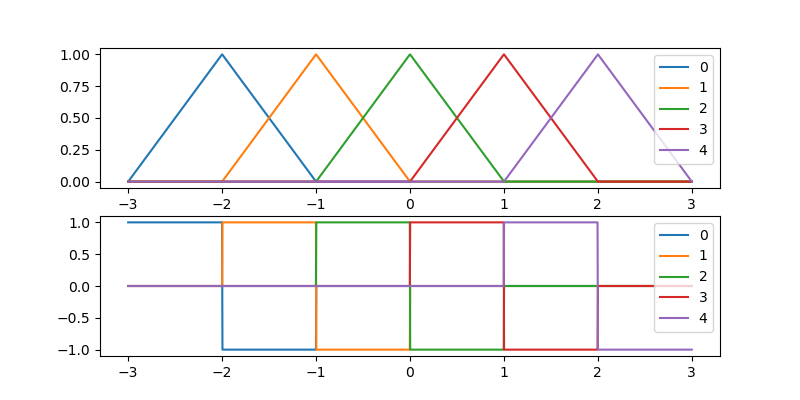

In [302]:
import torch
import xarray as xr

print('Creating nodes and domain samples')

# create a grid of n_c basis functions
n_nodes = 5
mid = n_nodes // 2
centers = np.arange(-2, 3)
centers = mre_pinn.fields.nd_coords([centers] * ndim)
centers = torch.as_tensor(centers, device='cuda')

# sample the domain around them at high resolution
n_samples = 7 * 200
x = np.linspace(-3, 3, n_samples, endpoint=True)
dx = x[1] - x[0]
x = mre_pinn.fields.nd_coords([x] * ndim)
x = torch.as_tensor(x, device='cuda')
x.requires_grad = True

print(centers.shape, x.shape)

print('Evaluating basis functions and gradients')

# evaluate each basis function at each domain sample
y = psi(x, centers)

# evaluate gradient of each basis function
J = torch.zeros((n_nodes**ndim, n_samples**ndim, ndim))
for i in range(n_nodes**ndim):
    J[i] = torch.autograd.grad(y[i], x, torch.ones_like(y[i]), retain_graph=True)[0]

y_shape = (n_nodes,) * ndim + (n_samples,) * ndim
y = y.reshape(y_shape).detach()
J = J.reshape(y_shape + (ndim,)).detach()
print(y.shape, J.shape)

fig, axes = plt.subplots(2, 1, figsize=(8,4))
axes[0].plot(x.detach().cpu().numpy(), y.detach().cpu().numpy().T, label=range(n_nodes))
axes[1].plot(x.detach().cpu().numpy(), J.detach().cpu().numpy()[...,0].T, label=range(n_nodes))
axes[0].legend()
axes[1].legend()

torch.Size([101]) torch.Size([101, 1])


<IPython.core.display.Javascript object>


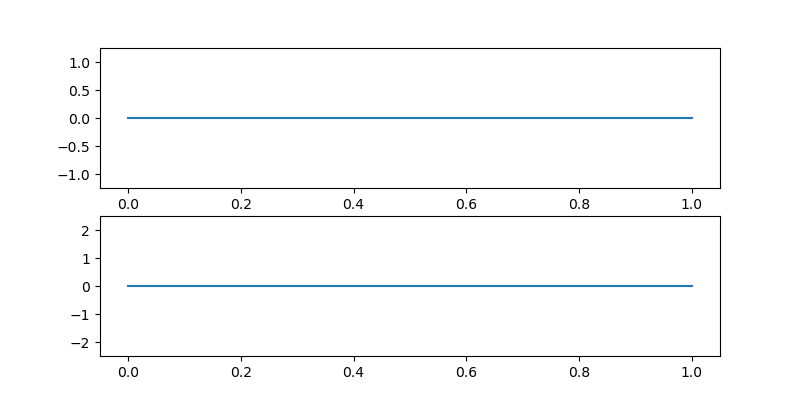

interactive(children=(FloatSlider(value=0.0, description='0', max=1.0, min=-1.0, step=0.01), FloatSlider(value…

<function __main__.update(**kwargs)>

In [29]:
# try a linear combination of the basis functions

import ipywidgets as widgets

coeffs = torch.zeros(n_nodes)

f = (coeffs[:,nax] * y).sum(axis=0)
df = (coeffs[:,nax,nax] * J).sum(axis=0)
print(f.shape, df.shape)

fig, axes = plt.subplots(2, 1, figsize=(8,4))
f_line, = axes[0].plot(x.detach().cpu().numpy(), f.detach().cpu().numpy())
df_line, = axes[1].plot(x.detach().cpu().numpy(), df.detach().cpu().numpy())

axes[0].set_ylim(-1.25, 1.25)
axes[1].set_ylim(-2.5, 2.5)

def update(**kwargs):
    for key, val in kwargs.items():
        coeffs[int(key)] = val
        f = (coeffs[:,nax] * y).sum(axis=0)
        df = (coeffs[:,nax,nax] * J).sum(axis=0)
        f_line.set_ydata(f.detach().cpu().numpy())
        df_line.set_ydata(df.detach().cpu().numpy())

sliders = {
    f'{i}': widgets.FloatSlider(
        value=0, min=-1, max=1, step=0.01
    ) for i in range(n_nodes)
}
widgets.interact(update, **sliders)

Computing basis function products
torch.Size([5, 1400]) torch.Size([5, 1400])
Computing basis function integrals
torch.Size([5]) torch.Size([5])
Caching basis function integrals
(-2,) 0.0 0.0
(-1,) 0.16666794302707244 -0.4992854591837824
(0,) 0.6666636030120858 0.9999994890662306
(1,) 0.16666794302707244 -0.499285459183782
(2,) 0.0 0.0
1.0


<IPython.core.display.Javascript object>


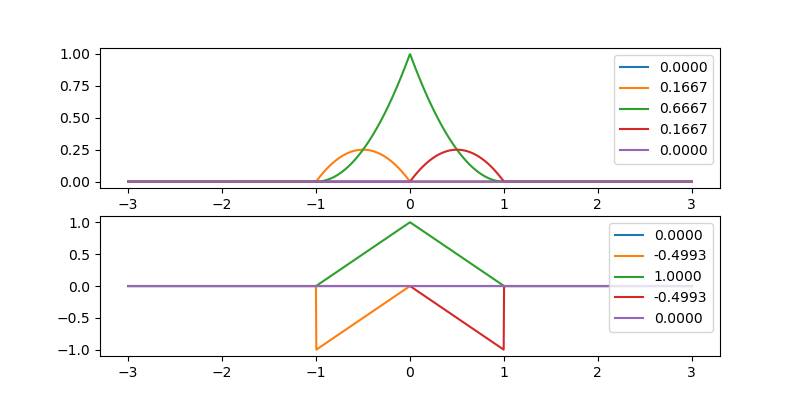

In [328]:
# compute basis function products and integrals

print('Computing basis function products')
origin = (slice(mid,mid+1),) * ndim
M_products = y[origin] * y
K_products = (y[...,nax] * J[origin] * J).sum(axis=-1)
print(M_products.shape, K_products.shape)

print('Computing basis function integrals')
M_integrals = (M_products * dx**ndim).sum(axis=1)
K_integrals = (K_products * dx**ndim).sum(axis=1)
print(M_integrals.shape, K_integrals.shape)

print('Caching basis function integrals')
M_cache = {}
K_cache = {}
max_dist = 0
dists = []
for idx in itertools.product(*[np.arange(n_nodes)] * ndim):
    diff = tuple(i - mid for i in idx)
    dist = np.linalg.norm(diff, np.inf)
    dists.append(dist)
    M_integral = M_integrals[idx].detach().cpu().numpy()
    K_integral = K_integrals[idx].detach().cpu().numpy()
    print(diff, M_integral, K_integral)
    if not np.isclose(M_integral, 0):
        M_cache[diff] = M_integral
        max_dist = max(dist, max_dist)
    if not np.isclose(K_integral, 0):
        K_cache[diff] = K_integral
        max_dist = max(dist, max_dist)

print(max_dist)
    
fig, axes = plt.subplots(2, 1, figsize=(8,4))
M_labels = [f'{i:.4f}' for i in M_integrals.detach().cpu().numpy()]
K_labels = [f'{i:.4f}' for i in K_integrals.detach().cpu().numpy()]
axes[0].plot(x.detach().cpu().numpy(), M_products.detach().cpu().numpy().T, label=M_labels)
axes[1].plot(x.detach().cpu().numpy(), K_products.detach().cpu().numpy().T, label=K_labels)
axes[0].legend()
axes[1].legend(loc='upper right')

In [261]:
# 2D basis function plot
for i in range(n_nodes):
    for j in range(n_nodes):
        
        # get the cache key
        key = (i-mid, j-mid)
        
        ax = M_axes[-1-j,i]
        mre_pinn.visual.imshow(ax, 1 - M_prod, resolution=dx, cmap='Greys_r', vmin=0, vmax=1)
        ax.text(0.1, 0.1, f'{diff} {M_integral:.4f}', color='black')
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax = K_axes[-1-j,i]
        vmax = max(J.max(), -J.min())
        mre_pinn.visual.imshow(ax, K_prod, resolution=dx, cmap='Greys_r', vmin=-vmax, vmax=vmax)
        ax.text(0.1, 0.1, f'{diff} {K_integral:.4f}', color='black')
        ax.set_xticks([])
        ax.set_yticks([])

NameError: name 'M_axes' is not defined

Establishing mesh connectivity
1.0
(80, 80, 1) (80, 80)


<IPython.core.display.Javascript object>


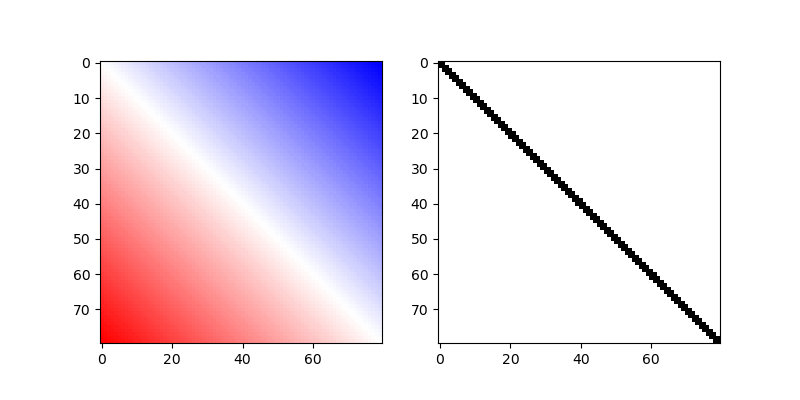

In [329]:
# start setting up the FEM problem

x = data.u.field.points() # remember that x has a frequency component!
u = data.u.field.values()
dx = 1e-3

print('Establishing mesh connectivity')

# pairwise Manhattan distance between nodes, in # nodes
nax = np.newaxis
diff = (x[:,nax,1:] - x[nax,:,1:]) / dx
diff = np.round(diff).astype(int)

print(max_dist)
conn = np.linalg.norm(diff, np.inf, axis=2) <= max_dist

print(diff.shape, conn.shape)

fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].imshow(diff, cmap='bwr')
axes[1].imshow(conn, cmap='Greys')

In [330]:
# assemble FEM matrices

n, d = u.shape
m = n * d
print(n, d, m)

# reshape displacement matrix
U = u.T.reshape(m, 1)

# assemble mass matrix
print('Assembling mass matrix')

row, col, values = [], [], []
for i in range(n):
    for j in range(n):
        key = tuple(diff[i,j])
        if M_cache.get(key, 0):
            row.append(i)
            col.append(j)
            values.append(M_cache[key])
            
M = scipy.sparse.coo_array((values, (row, col)), shape=(n, n))

# assemble stiffness matrix
print('Assembling stiffness matrix')

row, col, values = [], [], []
for i in range(n):
    for j in range(n):
        key = tuple(diff[i,j])
        if K_cache.get(key, 0):
            row.append(i)
            col.append(j)
            values.append(K_cache[key])

K = scipy.sparse.coo_array((values, (row, col)), shape=(n, n))

print('Converting to sparse diagonal format')
M = scipy.sparse.dia_array(M)
K = scipy.sparse.dia_array(K)

U.shape, M.shape, K.shape

80 1 80
Assembling mass matrix
Assembling stiffness matrix
Converting to sparse diagonal format


((80, 1), (80, 80), (80, 80))

In [334]:
# assemble matrix system

MM = scipy.sparse.block_diag([M] * ndim)
KK = scipy.sparse.bmat([[K.T]] * ndim)

MM.shape, KK.shape, U.shape

((80, 80), (80, 80), (80, 1))

In [337]:
# solve the linear system using least squares

rho = 1000
omega = 2 * np.pi * 80

G = scipy.sparse.linalg.lsqr(KK.multiply(U.T), rho * omega**2 * MM @ U)[0][:,nax]

G = G.reshape(data.mu.shape)
G = mre_pinn.utils.as_xarray(G, like=data.mu)
data['G'] = G

<IPython.core.display.Javascript object>


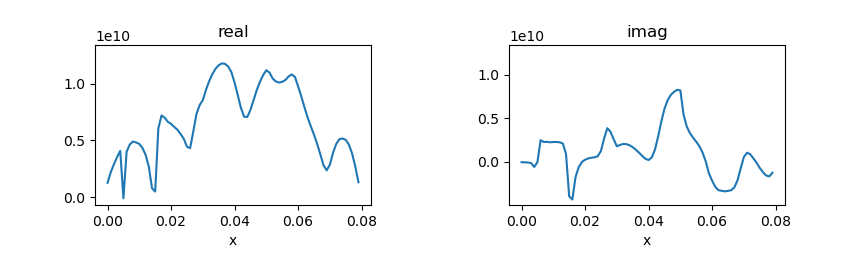

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [338]:
elast_kws = mre_pinn.visual.get_color_kws(data.G)

mre_pinn.visual.XArrayViewer(data.G, y=None, col='part', dpi=25, **elast_kws)

# Direct hetero inversion

Heterogeneous equation form

$$
    \mu \nabla^2 \mathbf{u} + \nabla \mu \cdot \nabla\mathbf{u} = -\rho \omega^2 \mathbf{u}
$$

In one dimension:

$$
    \mu \nabla^2 u + \nabla \mu \nabla u = -\rho \omega^2 u \\
$$

Suppose we have $N$ uniform samples of $u$ and a finite difference gradient operator $\nabla \in \mathbb{R}^{N \times N}$:

$$
\begin{align}
             u &\in \mathbb{C}^N &\qquad        \mu &\in \mathbb{C}^N \\
    \nabla   u &\in \mathbb{C}^N &\qquad \nabla \mu &\in \mathbb{C}^N \\
    \nabla^2 u &\in \mathbb{C}^N &\qquad \\
\end{align}
$$

We have two unknowns to solve for, $\mu$ and $\nabla \mu$.

We have $N$ sets of simultaneous linear equations:

$$
\begin{align}
    \mu_i (\nabla^2 u)_i + (\nabla \mu)_i (\nabla u)_i = -\rho \omega^2 u_i \\
\end{align}
$$

Which can be rearranged into a linear system:

$$
\begin{bmatrix}
    \nabla^2 u & \nabla u
\end{bmatrix} \begin{bmatrix}
    \mathbf{I} \\
    \nabla
\end{bmatrix} \mu = -\rho \omega^2 u
$$

Note that the Helmholtz system is:

$$
\begin{bmatrix}
    \nabla^2 u
\end{bmatrix} \begin{bmatrix}
    \mathbf{I} \\
\end{bmatrix} \mu = -\rho \omega^2 u
$$


In [397]:
# load the data set

data, test_data = mre_pinn.data.load_bioqic_dataset(
    data_root='../data/BIOQIC',
    data_name='fem_box',
    frequency=80,
    xyz_slice='1D',
    downsample=2,
    verbose=False
)
ndim = 1

data

<xarray.Dataset>
Dimensions:         (frequency: 1, x: 80, component: 1)
Coordinates:
  * frequency       (frequency) float64 80.0
  * x               (x) float64 0.0 0.001 0.002 0.003 ... 0.077 0.078 0.079
    y               float64 0.075
    z               float64 0.0
  * component       (component) <U1 'z'
    spatial_region  (x) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Data variables:
    u               (frequency, x, component) complex128 (-2.0610768547282833...
    mu              (frequency, x) complex128 (3000+502.6548245743669j) ... (...
    Lu              (frequency, x, component) complex128 (0.09408754645972661...
    Mu              (frequency, x) complex128 (5467.739651386013+636.09434909...

In [431]:
x = data.u.field.points()
u = data.u.field.values()
print(x.shape, u.shape)

n, d = u.shape
dx = 1e-3

rho = 1000
omega = 80

rhs = rho * (2 * np.pi * omega)**2 * u

# central differences gradient operator

lower_diag = -np.ones(n - 1) / (2 * dx)
main_diag  =  np.zeros(n) 
upper_diag =  np.ones(n - 1) / (2 * dx)

main_diag[0]  = -1 / dx
upper_diag[0] =  1 / dx

lower_diag[-1] = -1 / dx
main_diag[-1]  =  1 / dx

# create differential operators
L = scipy.sparse.diags(
    [lower_diag, main_diag, upper_diag],
    offsets=[-1, 0, 1],
    shape=(n, n)
)**2

main_diag  = -np.ones(n) / dx
upper_diag =  np.ones(n - 1) / dx

D = scipy.sparse.diags(
    [main_diag, upper_diag],
    offsets=[0, 1],
    shape=(n, n)
)

# Helmholtz inversion
Lu = L @ u

diag_Lu = scipy.sparse.diags(
    [Lu[:,0]], offsets=[0], shape=(n, n)
)
print(diag_Lu.shape)

Mu = scipy.sparse.linalg.lsqr(diag_Lu, -rho * (2 * np.pi * omega)**2 * u)[0]

# heterogeneous inversion
Du = D @ u
Lu = L @ u

diag_Du = scipy.sparse.diags(
    [Du[:,0]], offsets=[0], shape=(n, n)
)
diag_Lu = scipy.sparse.diags(
    [Lu[:,0]], offsets=[0], shape=(n, n)
)

I = scipy.sparse.diags(
    [np.ones(n)], offsets=[0], shape=(n, n)
)

A = scipy.sparse.bmat([[diag_Lu, diag_Du]])
B = scipy.sparse.bmat([[I], [D]])
K = A @ B

Mu = scipy.sparse.linalg.lsqr(K, -rho * (2 * np.pi * omega)**2 * u)[0]

data['Du'] = mre_pinn.utils.as_xarray(Du.reshape(data.u.shape),  like=data.u)
data['Lu'] = mre_pinn.utils.as_xarray(Lu.reshape(data.u.shape),  like=data.u)
data['Mu'] = mre_pinn.utils.as_xarray(Mu.reshape(data.mu.shape), like=data.mu)

(80, 2) (80, 1)
(80, 80)


<IPython.core.display.Javascript object>


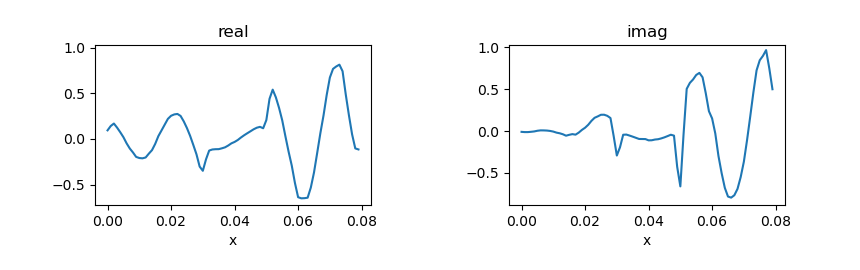

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

<IPython.core.display.Javascript object>


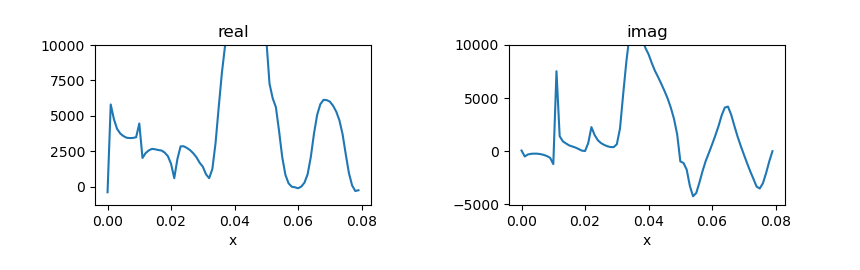

interactive(children=(SelectionSlider(description='domain', options=(('space', 0), ('frequency', 1)), value=0)…

In [432]:
wave_kws = mre_pinn.visual.get_color_kws(data.u)
grad_kws = mre_pinn.visual.get_color_kws(data.Du)
laplace_kws = mre_pinn.visual.get_color_kws(data.Lu)
elast_kws = mre_pinn.visual.get_color_kws(data.mu)

mre_pinn.visual.XArrayViewer(data.Lu, y=None, col='part', dpi=25, **laplace_kws)
mre_pinn.visual.XArrayViewer(data.Mu, y=None, col='part', dpi=25, **elast_kws)

# Trying sfepy

In [ ]:
from sfepy.mesh.mesh_generators import gen_block_mesh
from sfepy.postprocess.plot_cmesh import plot_cmesh
from sfepy.discrete import FieldVariable, Material, Integral, Function, Equation, Equations, Problem
from sfepy.discrete.fem import Mesh, FEDomain, Field
from sfepy.terms import Term

dx = 1e-3
dims = [79 * dx, 99 * dx]
shape = [80, 100]
center = [79 * dx / 2, 99 * dx / 2]

mesh = gen_block_mesh(dims, shape, center)
domain = FEDomain('domain', mesh)

domain.get_mesh_bounding_box()
omega = domain.create_region('Omega', 'all')
gamma = domain.create_region('Gamma', 'vertices of set data')


In [ ]:
u_field = Field.from_args('fu', np.complex64, 1, omega)
mu_field = Field.from_args('fmu', np.complex64, 2, omega)

u = FieldVariable('u', 'unknown', u_field)
w = FieldVariable('w', 'test', u_field, primary_var_name='u')
mu = FieldVariable('mu', 'unknown', mu_field)

integral = Integral('int', order=1)

f_trac = Term.new('', integral, omega, )
f_body = Term.new('', integral, omega, )